In [ ]:
# Cell 1: Import libraries and load the CSV data
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings("ignore")

# Load the CSV file (make sure "fake_users.csv" is uploaded to your Colab environment)
df = pd.read_csv("fake_users.csv")
print("Data preview:")
print(df.head())

Data preview:
   user_id                           courses       college location   friends
0        1            Math;Physics;Chemistry  University 1   City 1  23;45;12
1        2           Biology;English;History  University 2   City 2   5;33;47
2        3    Computer Science;Art;Economics  University 3   City 3   1;29;50
3        4  Philosophy;Statistics;Psychology  University 4   City 4  10;17;39
4        5     Math;Biology;Computer Science  University 5   City 5   2;28;44


In [ ]:
# Cell 2: Preprocess data

# Convert the courses string into a list for each user
df['courses_list'] = df['courses'].apply(lambda x: x.split(';'))

# One-hot encode the courses using MultiLabelBinarizer
mlb = MultiLabelBinarizer()
courses_encoded = pd.DataFrame(mlb.fit_transform(df['courses_list']),
                               columns=mlb.classes_,
                               index=df.index)

# One-hot encode the 'college' and 'location' columns
college_encoded = pd.get_dummies(df['college'], prefix='college')
location_encoded = pd.get_dummies(df['location'], prefix='location')

# Combine all the encoded features into a single DataFrame
features = pd.concat([courses_encoded, college_encoded, location_encoded], axis=1)
print("Feature vector shape:", features.shape)

Feature vector shape: (100, 82)


In [ ]:
# Cell 3: Build the KNN model

# Set n_neighbors a bit higher than the number of recommendations you plan to request
knn = NearestNeighbors(n_neighbors=10, metric='cosine')
knn.fit(features)

# Compute nearest neighbors for all users
distances, indices = knn.kneighbors(features)
print("KNN model built and nearest neighbors computed.")

KNN model built and nearest neighbors computed.


In [ ]:
# Cell 4: Recommendation function with explanation

def get_explanation(user_idx, candidate_idx):
    """Compare features of the user and candidate to build an explanation string."""
    explanation_parts = []

    # Compare courses (using the original courses_list column)
    user_courses = set(df.iloc[user_idx]['courses_list'])
    candidate_courses = set(df.iloc[candidate_idx]['courses_list'])
    common_courses = user_courses.intersection(candidate_courses)
    if common_courses:
        explanation_parts.append("shared course(s): " + ", ".join(common_courses))

    # Compare college
    if df.iloc[user_idx]['college'] == df.iloc[candidate_idx]['college']:
        explanation_parts.append("same college: " + df.iloc[user_idx]['college'])

    # Compare location
    if df.iloc[user_idx]['location'] == df.iloc[candidate_idx]['location']:
        explanation_parts.append("same location: " + df.iloc[user_idx]['location'])

    # If no common features are found, state that too
    if not explanation_parts:
        explanation_parts.append("no common features found")

    return "; ".join(explanation_parts)

def get_recommendations(user_id, n=5):
    """
    Given a user_id, returns up to n recommended user_ids along with an explanation
    of the recommendation basis, excluding users already connected as friends.
    """
    # Find the row index for the given user_id
    user_index = df.index[df['user_id'] == user_id].tolist()[0]

    # Get the current friends for the user from the 'friends' column (semicolon-separated)
    friend_str = df.iloc[user_index]['friends']
    if pd.isna(friend_str) or friend_str.strip() == "":
        current_friends = []
    else:
        # Convert friend IDs from string to integers
        current_friends = [int(x) for x in friend_str.split(';') if x.strip().isdigit()]

    # Get the indices of nearest neighbors for the user
    neighbor_indices = indices[user_index]

    recommendations = []
    # Loop through neighbor indices and filter out the user themself and existing friends
    for idx in neighbor_indices:
        candidate_user_id = df.iloc[idx]['user_id']
        if candidate_user_id == user_id or candidate_user_id in current_friends:
            continue

        # Generate explanation for this candidate recommendation
        explanation = get_explanation(user_index, idx)
        recommendations.append((candidate_user_id, explanation))
        if len(recommendations) >= n:
            break

    return recommendations

# Example: Get recommendations for user_id 10
user_id = 10
recs = get_recommendations(user_id, n=5)
print(f"Recommendations for user_id {user_id}:")
for rec in recs:
    print(f"User {rec[0]} -> {rec[1]}")

Recommendations for user_id 10:
User 50 -> shared course(s): History, English, Computer Science; same college: University 10
User 90 -> shared course(s): History, English, Computer Science; same college: University 10
User 70 -> shared course(s): History, English, Computer Science; same location: City 10
User 40 -> shared course(s): History, English, Computer Science; same location: City 10
User 100 -> shared course(s): History, English, Computer Science; same location: City 10


In [ ]:
# Cell 5: Testing the recommendation function on several user_ids

test_user_ids = [1, 25, 50, 75, 100]
for uid in test_user_ids:
    recs = get_recommendations(uid, n=5)
    print(f"\nRecommendations for user_id {uid}:")
    for rec in recs:
        print(f"User {rec[0]} -> {rec[1]}")


Recommendations for user_id 1:
User 31 -> shared course(s): Chemistry, Math, Physics; same location: City 1
User 41 -> shared course(s): Chemistry, Math, Physics; same college: University 1
User 81 -> shared course(s): Chemistry, Math, Physics; same college: University 1
User 61 -> shared course(s): Chemistry, Math, Physics; same location: City 1
User 91 -> shared course(s): Chemistry, Math, Physics; same location: City 1

Recommendations for user_id 25:
User 55 -> shared course(s): Computer Science, Math, Biology; same location: City 25
User 65 -> shared course(s): Computer Science, Math, Biology; same college: University 25
User 85 -> shared course(s): Computer Science, Math, Biology; same location: City 25
User 75 -> shared course(s): Computer Science, Math, Biology
User 15 -> shared course(s): Computer Science, Math, Biology

Recommendations for user_id 50:
User 10 -> shared course(s): History, English, Computer Science; same college: University 10
User 90 -> shared course(s): His

In [ ]:
# Cell A: Import libraries for visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
# Cell B: Prepare data for visualization

# Choose a user to visualize (for example, user_id 10)
current_user_id = 10
user_index = df.index[df['user_id'] == current_user_id].tolist()[0]

# Reduce the feature space to 2D using PCA
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

# Coordinates of the current user in 2D
current_coord = features_2d[user_index]

# Retrieve neighbor indices from the KNN model (computed earlier)
neighbor_indices = indices[user_index]

# Get the current user's friend list from the 'friends' column
friend_str = df.iloc[user_index]['friends']
if pd.isna(friend_str) or friend_str.strip() == "":
    current_friends = []
else:
    current_friends = [int(x) for x in friend_str.split(';') if x.strip().isdigit()]

# Separate neighbor indices into recommended (not friends) and excluded (already friends or self)
recommended_indices = []
excluded_indices = []
for idx in neighbor_indices:
    candidate_user_id = df.iloc[idx]['user_id']
    if candidate_user_id == current_user_id or candidate_user_id in current_friends:
        excluded_indices.append(idx)
    else:
        recommended_indices.append(idx)

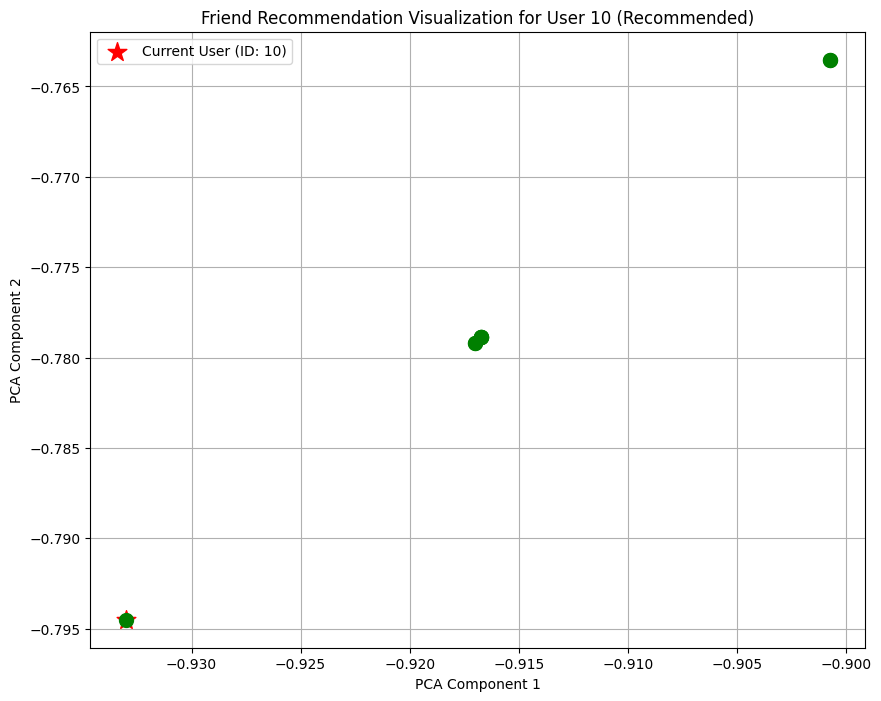

In [ ]:
# Cell C: Plot current user and recommended neighbors without explanation annotations

plt.figure(figsize=(10, 8))

# Plot the current user as a red star
plt.scatter(current_coord[0], current_coord[1], color='red', marker='*', s=200,
            label=f'Current User (ID: {current_user_id})')

# Plot recommended neighbors as green circles
for idx in recommended_indices:
    candidate_coord = features_2d[idx]
    plt.scatter(candidate_coord[0], candidate_coord[1], color='green', marker='o', s=100)

plt.title(f"Friend Recommendation Visualization for User {current_user_id} (Recommended)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

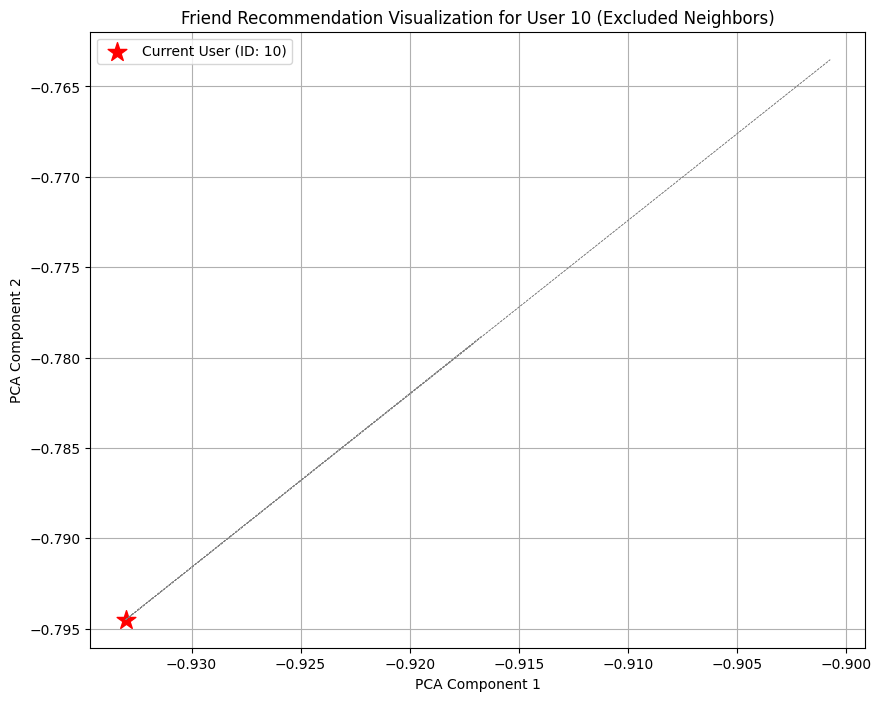

In [ ]:
# Cell D: Plot excluded neighbors and draw connecting lines

plt.figure(figsize=(10, 8))

# Plot the current user as a red star for context
plt.scatter(current_coord[0], current_coord[1], color='red', marker='*', s=200,
            label=f'Current User (ID: {current_user_id})')

# Plot excluded neighbors as blue squares (already friends)
for idx in excluded_indices:
    # Skip the current user itself if present in the list
    if idx == user_index:
        continue
    candidate_coord = features_2d[idx]
    plt.scatter(candidate_coord[0], candidate_coord[1], color='blue', marker='s', s=100)

# Draw dashed lines from the current user to each neighbor point (both recommended and excluded)
for idx in neighbor_indices:
    candidate_coord = features_2d[idx]
    plt.plot([current_coord[0], candidate_coord[0]], [current_coord[1], candidate_coord[1]],
             color='gray', linestyle='--', linewidth=0.5)

plt.title(f"Friend Recommendation Visualization for User {current_user_id} (Excluded Neighbors)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()